# Основы глубинного обучения, майнор ИАД

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Общая информация

Дата выдачи: 06.10.2021

Мягкий дедлайн: 23:59MSK 25.10.2021

Жесткий дедлайн: 23:59MSK 28.10.2021

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. За каждый день просрочки снимается 1 балл. Сдавать задание после жёсткого дедлайна сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит предсказывать год выпуска песни по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [1]:
import torch
from torch import nn
import torch.optim as optim
import pandas as pd
import numpy as np
import random
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import wandb
from tqdm.notebook import tqdm

In [2]:
%load_ext lab_black


def set_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


wandb.login()
set_seed(3407)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

wandb: Currently logged in as: seara (use `wandb login --relogin` to force relogin)


device(type='cuda')

In [3]:
# !wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

In [4]:
df = pd.read_csv("data.txt.zip", header=None)
df.head()

0         1         2         3         4         5         6         7   \
0  2001  49.94357  21.47114  73.07750   8.74861 -17.40628 -13.09905 -25.01202   
1  2001  48.73215  18.42930  70.32679  12.94636 -10.32437 -24.83777   8.76630   
2  2001  50.95714  31.85602  55.81851  13.41693  -6.57898 -18.54940  -3.27872   
3  2001  48.24750  -1.89837  36.29772   2.58776   0.97170 -26.21683   5.05097   
4  2001  50.97020  42.20998  67.09964   8.46791 -15.85279 -16.81409 -12.48207   

         8         9   ...        81         82        83        84        85  \
0 -12.23257   7.83089  ...  13.01620  -54.40548  58.99367  15.37344   1.11144   
1  -0.92019  18.76548  ...   5.66812  -19.68073  33.04964  42.87836  -9.90378   
2  -2.35035  16.07017  ...   3.03800   26.05866 -50.92779  10.93792  -0.07568   
3 -10.34124   3.55005  ...  34.57337 -171.70734 -16.96705 -46.67617 -12.51516   
4  -9.37636  12.63699  ...   9.92661  -55.95724  64.92712 -17.72522  -1.49237   

         86         87        88         89        90  
0 -23.08793   68.40795  -1.82223  -27.46348   2.26327  
1 -32.22788   70.49388  12.04941   58.43453  26.92061  
2  43.20130 -115.00698  -0.05859   39.67068  -0.66345  
3  82.58061  -72.08993   9.90558  199.62971  18.85382  
4  -7.50035   51.76631   7.88713   55.66926  28.74903  

[5 rows x 91 columns]

In [5]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

In [6]:
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

In [7]:
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).reshape(1, -1)[0]
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).reshape(1, -1)[0]

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

In [8]:
clf = Ridge()
clf.fit(X_train_scaled, y_train_scaled)

Ridge()

In [9]:
y_pred = clf.predict(X_test_scaled)
mean_squared_error(y_test_scaled, y_pred, squared=False) * scaler_y.scale_

array([9.51016082])

In [10]:
a = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).reshape(1, -1)[0]
best_constant = a.mean()
print("Качество при наилучшем константном прогнозе")
mean_squared_error(
    y_test, [best_constant for i in range(len(y_test_scaled))], squared=False
)

Качество при наилучшем константном прогнозе


10.851920805959942

## Задание 1. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из ячейки ниже.



In [11]:
# def set_random_seed(seed):
#     torch.backends.cudnn.deterministic = True
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)
#     np.random.seed(seed)
#     random.seed(seed)

torch.utils.data.DatasetВы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться следующими сигнатурами функций. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

In [12]:
class DataSet(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.x[idx, :], dtype=torch.float),
            torch.tensor([self.y[idx]], dtype=torch.float),
        )

In [13]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.linear1 = nn.Linear(90, 45)
        self.batchnorm1 = nn.BatchNorm1d(45)
        self.linear2 = nn.Linear(45, 10)
        self.batchnorm2 = nn.BatchNorm1d(10)
        self.linear3 = nn.Linear(10, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        return self.linear3(x)

In [14]:
train_set = DataSet(X_train_scaled, y_train_scaled)
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=64, num_workers=8, pin_memory=True, shuffle=True
)

test_set = DataSet(X_test_scaled, y_test_scaled)
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=64, num_workers=8, pin_memory=True, shuffle=True
)

model = Model()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.0001)
criterion = nn.MSELoss()

model.to(device)

Model(
  (linear1): Linear(in_features=90, out_features=45, bias=True)
  (batchnorm1): BatchNorm1d(45, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=45, out_features=10, bias=True)
  (batchnorm2): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [15]:
wandb.init(project="homework-1", name="final_model")
wandb.watch(model)

[]

In [16]:
NUM_EPOCH = 5

In [17]:
def train(model, optimizer, criterion, train_loader, test_loader):
    """
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
        test_loader - torch.utils.data.Dataloader with test set
                      (if you wish to validate during training)
    """
    train_loss = []
    model.train()

    for x_train, y_train in tqdm(train_loader):

        x_train = x_train.to(device)
        y_train = y_train.to(device)

        optimizer.zero_grad()
        y_pred = model(x_train)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())

    val_loss = []
    model.eval()

    with torch.no_grad():
        for x_test, y_test in tqdm(test_loader):

            x_test = x_test.to(device)
            y_test = y_test.to(device)

            y_pred = model(x_test)
            loss = criterion(y_pred, y_test)  # criterion = nn.MSELoss()

            val_loss.append(loss.item())

    wandb.log(
        {
            "Train loss": np.sqrt(np.mean(train_loss)) * scaler_y.scale_,
            "Val loss": np.sqrt(np.mean(val_loss)) * scaler_y.scale_,
        }
    )
    print(
        "Epoch: {epoch}, loss: {loss}".format(
            epoch=epoch, loss=np.sqrt(np.mean(val_loss)) * scaler_y.scale_
        )
    )


def test(model, criterion, test_loader):
    """
    params:
        model - torch.nn.Module to be evaluated on test set
        criterion - loss function from torch.nn
        test_loader - torch.utils.data.Dataloader with test set
    ----------
    returns:
        predicts - torch.tensor with shape (len(test_loader.dataset), ),
                   which contains predictions for test objects
    """
    val_loss = []
    model.eval()

    with torch.no_grad():
        for x_test, y_test in tqdm(test_loader):

            x_test = x_test.to(device)
            y_test = y_test.to(device)

            y_pred = model(x_test)
            loss = criterion(y_pred, y_test)  # criterion = nn.MSELoss()

            val_loss.append(loss.item())

    print("Test loss", np.sqrt(np.mean(val_loss)) * scaler_y.scale_)

In [18]:
for epoch in range(NUM_EPOCH):
    train(model, optimizer, criterion, train_loader, test_loader)

  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch: 0, loss: [8.92956534]


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch: 1, loss: [8.85153756]


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch: 2, loss: [8.84581518]


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch: 3, loss: [8.81845806]


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch: 4, loss: [8.77947616]


In [19]:
test(model, criterion, test_loader)

  0%|          | 0/807 [00:00<?, ?it/s]

Test loss [8.77982286]


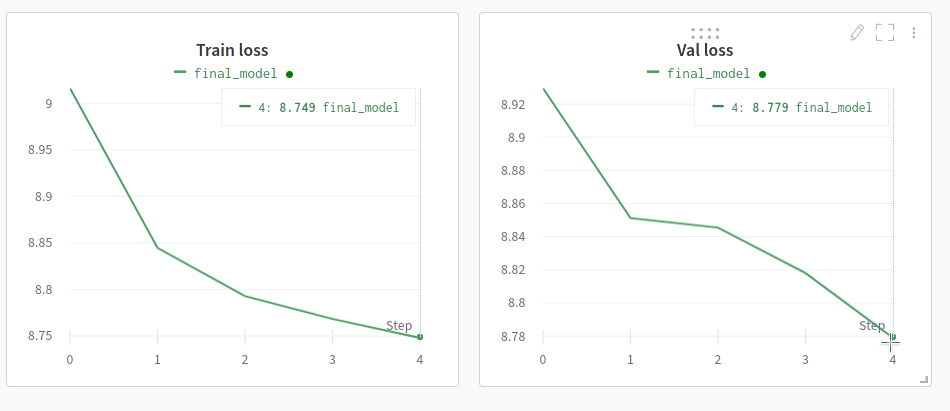

## Задание 2. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

Для рисовки графиков использовал wandb.io

Самая первая архитектура, что с сделал выглядела вот так:

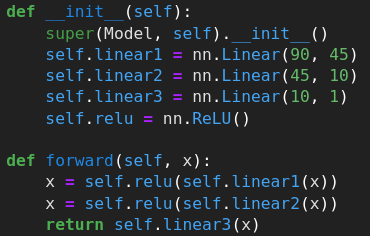

Я тестировал его с оптимайзером Adam и менял lr и batch_size.
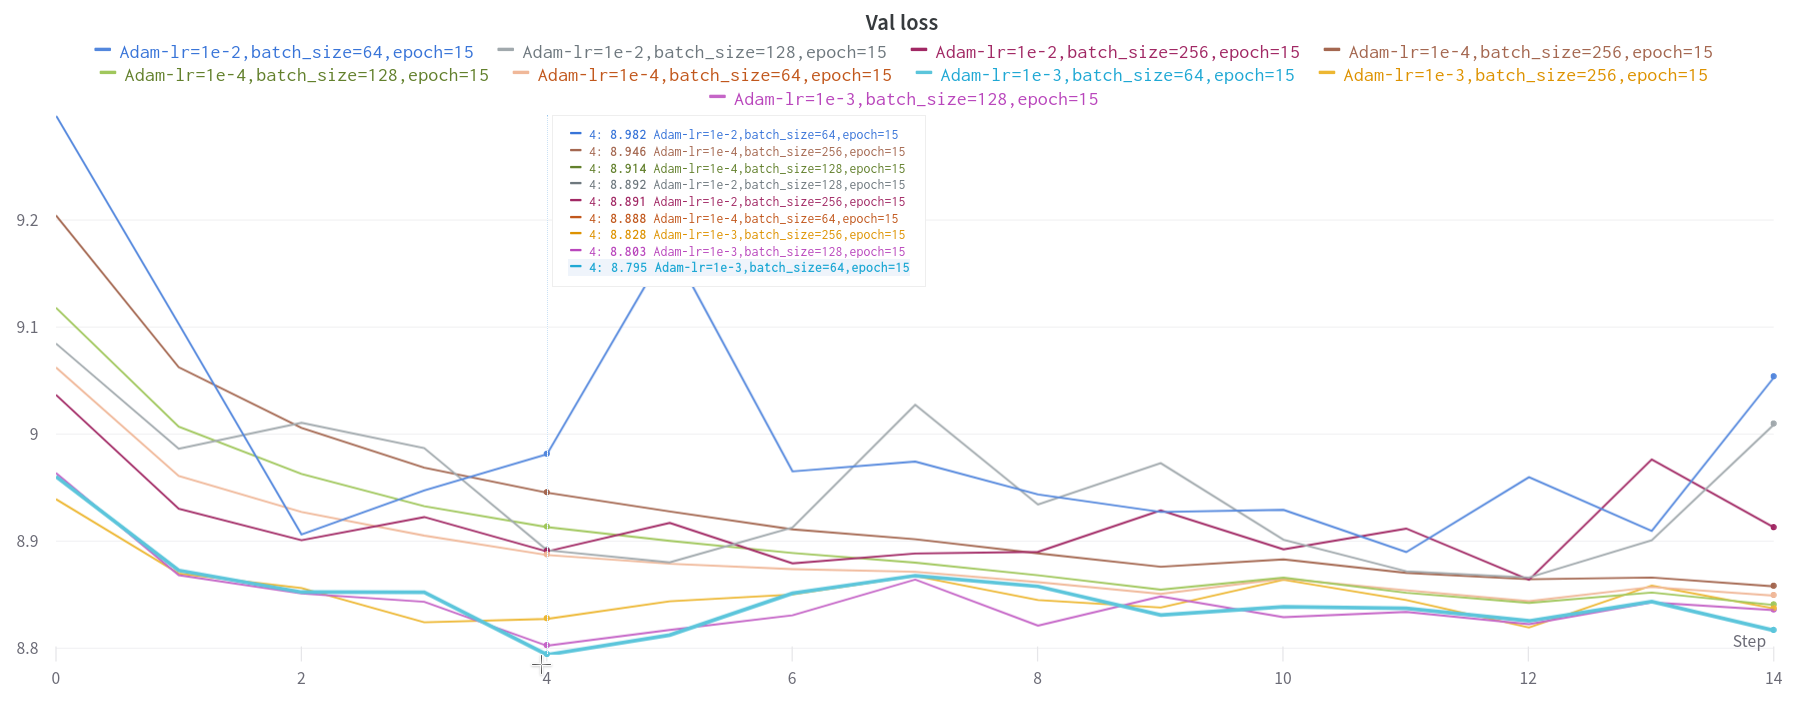
Видно, что лучшее RMSE=8.795 в модели c Adam(lr=1e-4) и с batch_size = 64. 5 эпох достаточно и дальше идёт переобучение.

Я подумал, может быть проблема в оптимайзере и решил обучать с помощью SGD.
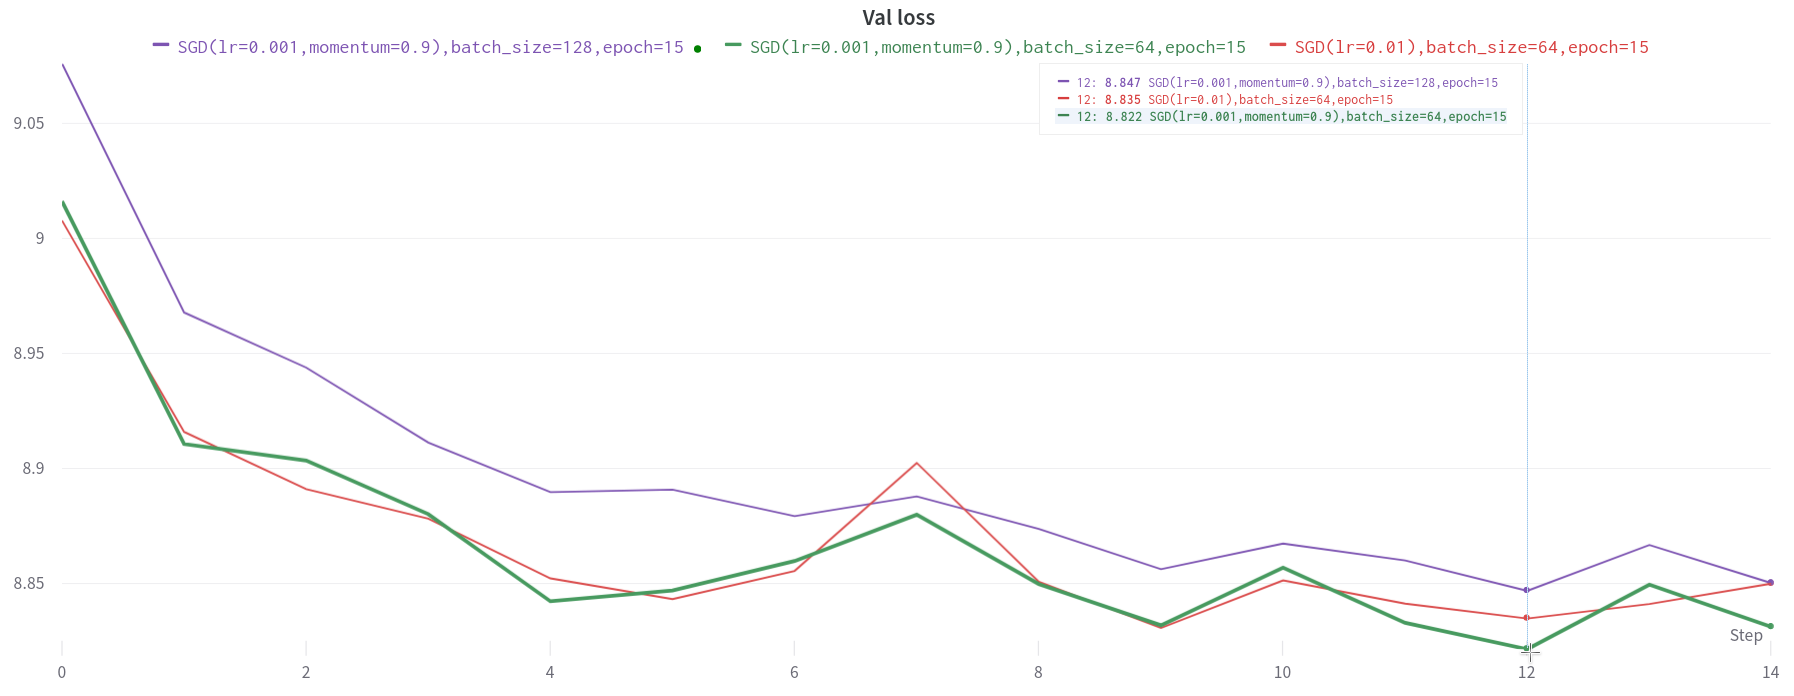
Ну по графику все видно: Adam в среднем лучше SGD. Возвращаюсь на Adam.

Поменяю(расширю) архитектуру нейросети, теперь она выглядит вот так:

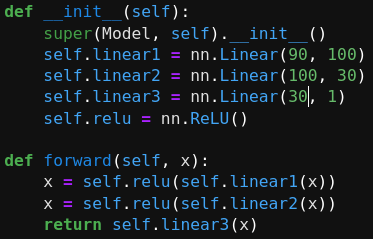

Получилось не очень, графики стало сильнее трясти.
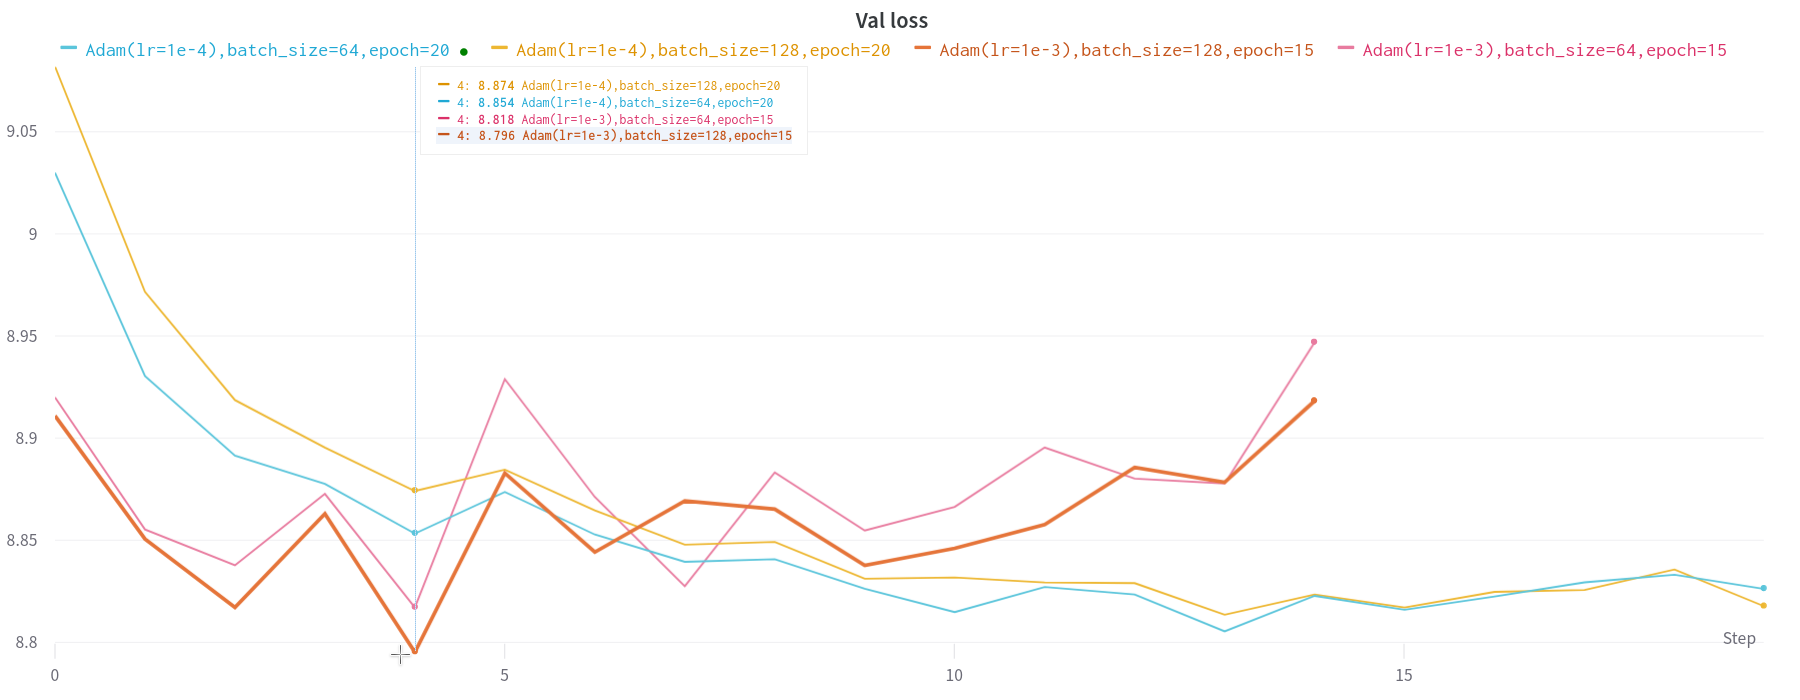

Теперь попробую наоборот уменьшить количество нейронов.

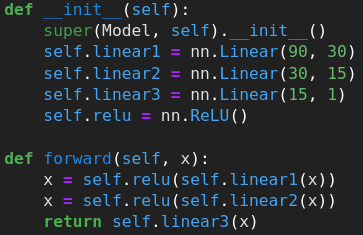

Стало лучше, но у самой первой архитектуры был меньше loss:
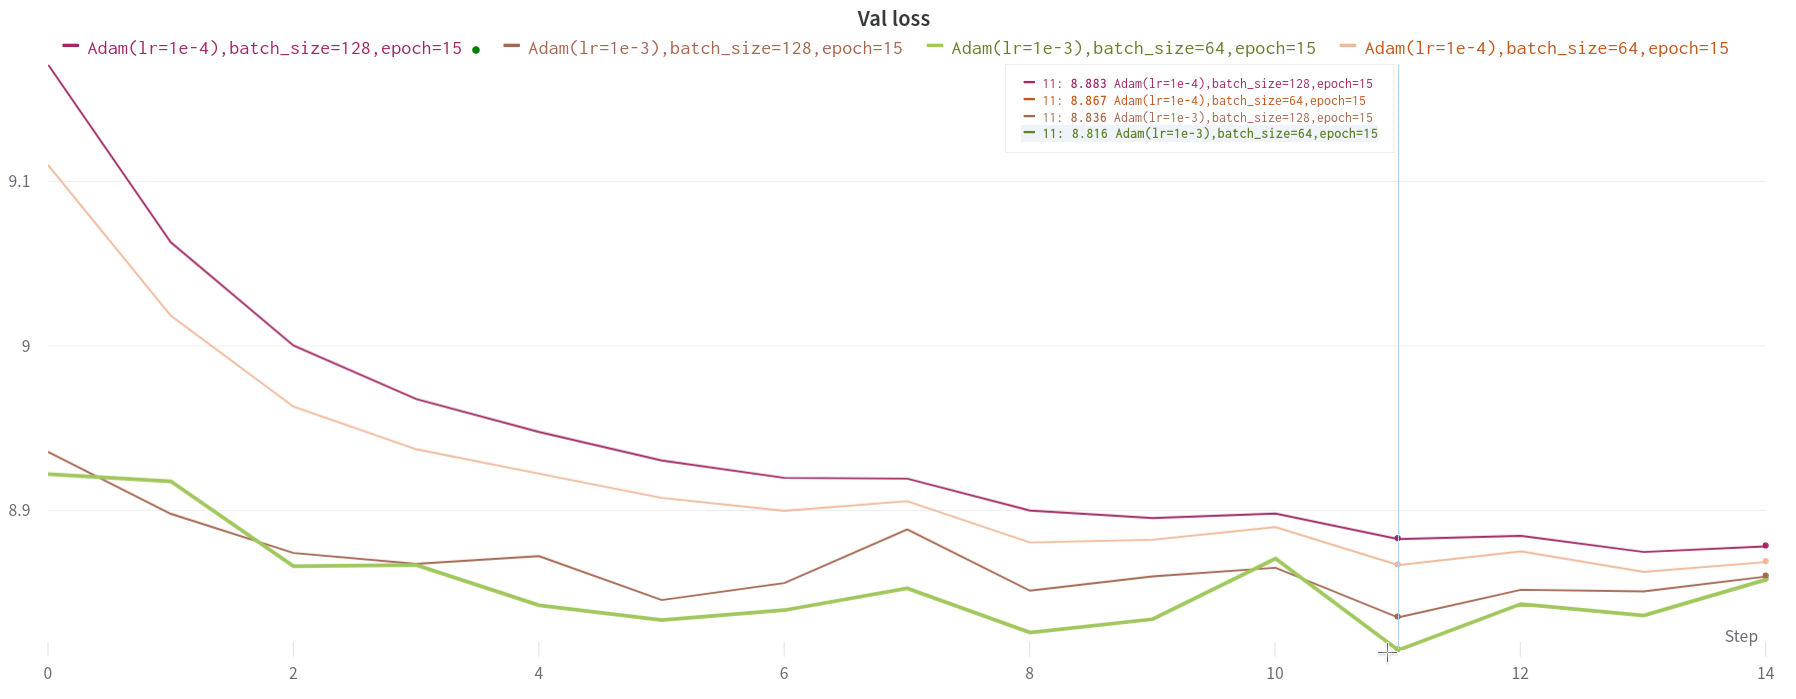

Возвращаюсь на самую первую архитектуру. Узнал, что в Adam есть параметр weight_decay, который тоже влияет на RMSE. Я обучил много моделей с разными параматрами weight_decay, batch_size, lr и всё равно не получилось пробить порог.


Самый лучший результат RMSE=8.785 на 12 эпохе при lr=0.0001, batch_size=16, weight_decay=0.001.
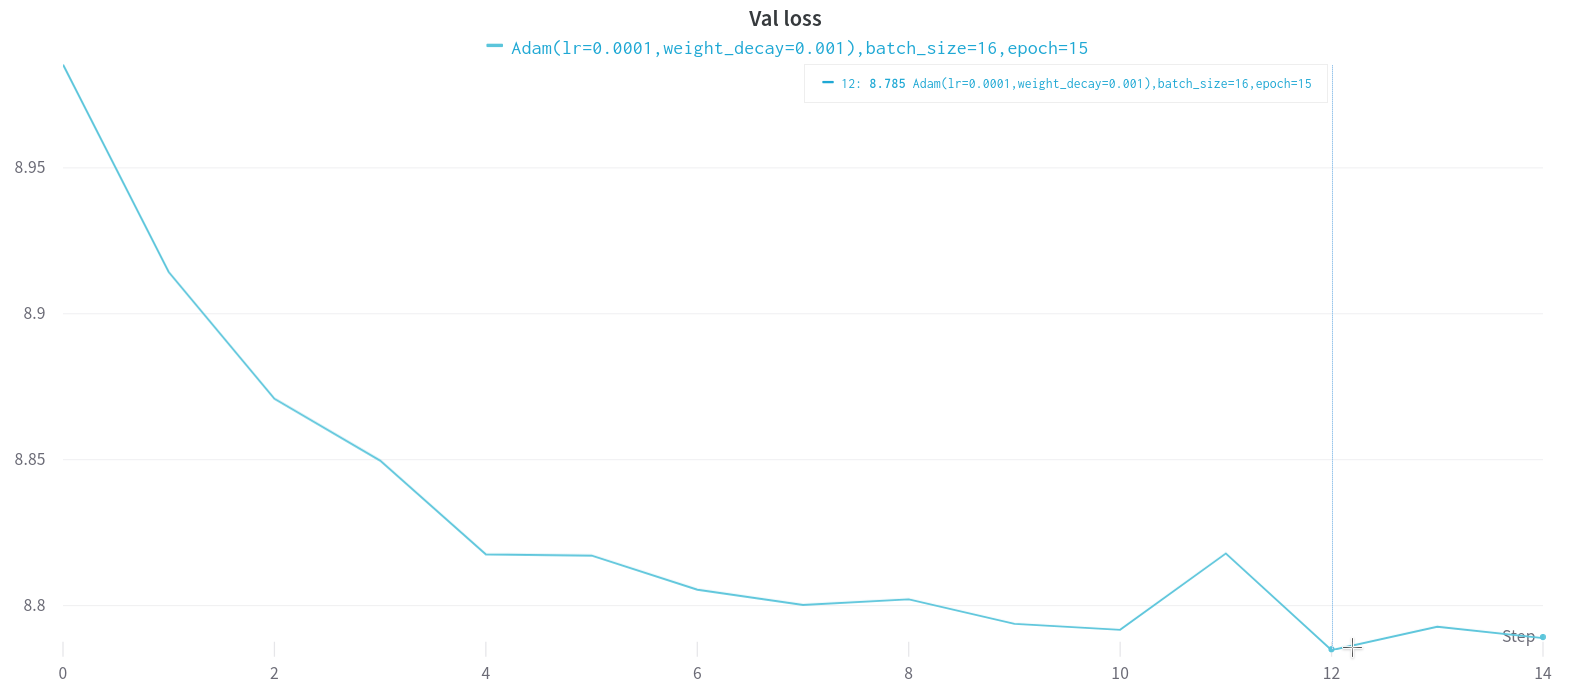

Теперь попробую добавить dropout=0.4. Архитектура выглядит вот так:

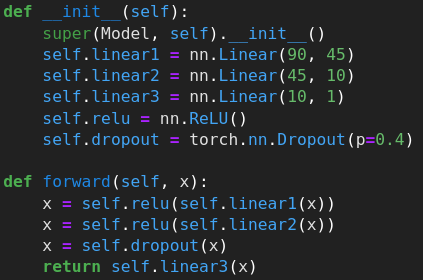

Сразу заметил, что графики lossа стало меньше трясти по сравнению с предыдущими архитектурами. Лосс плавно уменьшается с каждой эпохой, но он стал больше.
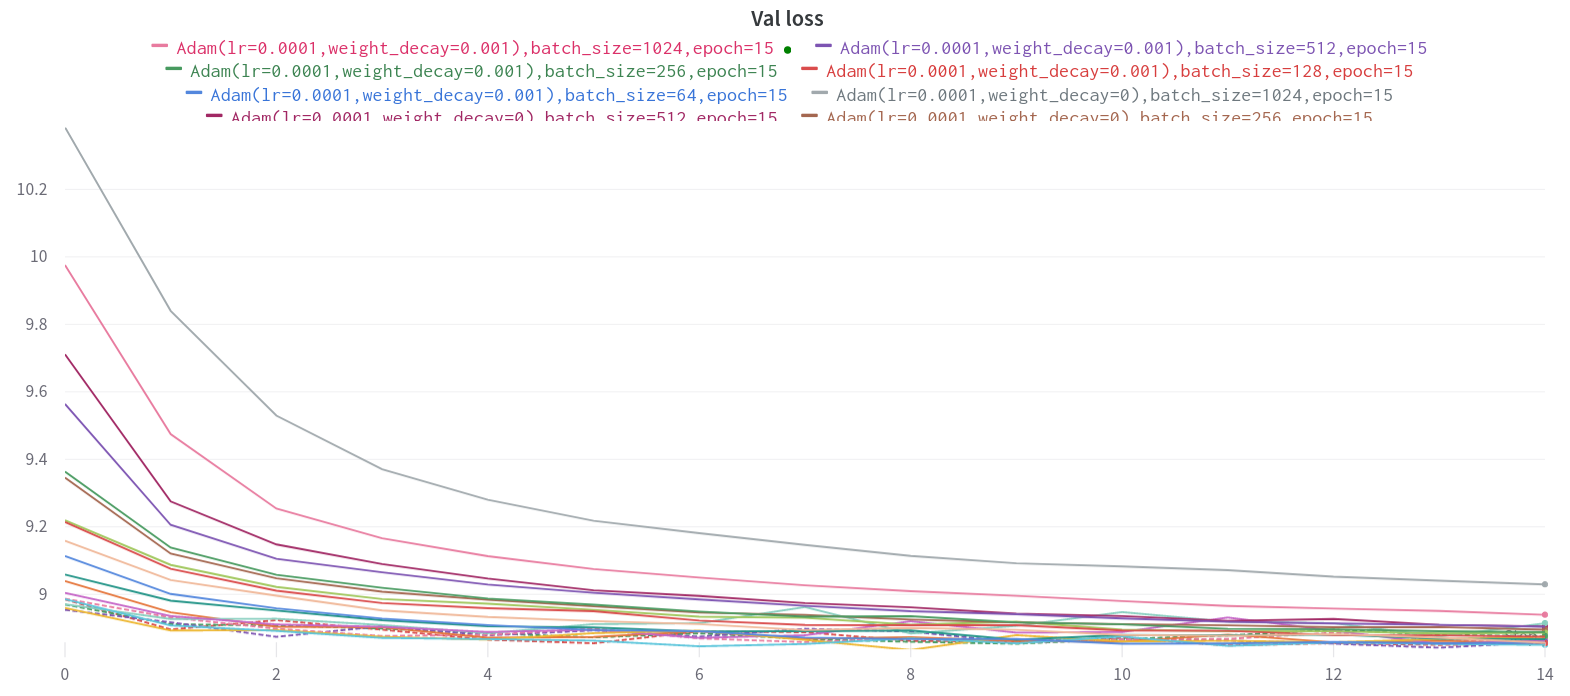

По графикам можно сделать вывод что при lr=1e-4 на графиках плавно снижается лосс, без скачков, но очень быстро выходит на асимптоту, что не даёт пробить порог RMSE. Графики при lr=1e-3 больше трясёт, но и лосс у них в среднем ниже

Dropout не сильно мне помог. Решил добавить batchnorm. Теперь архитектура выглядит вот так.

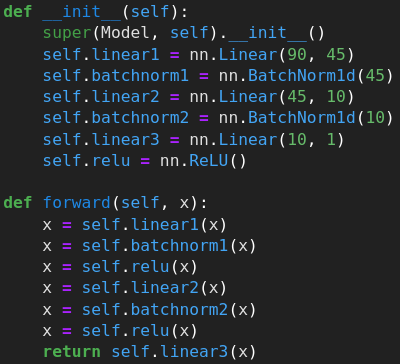

Я также попробовал разные параметры на этой архитектуре и получилось выбить RMSE=8.77 при lr=1e-3, weight_decay=0.0001, NUM_EPOCH=5, batch_size=64.

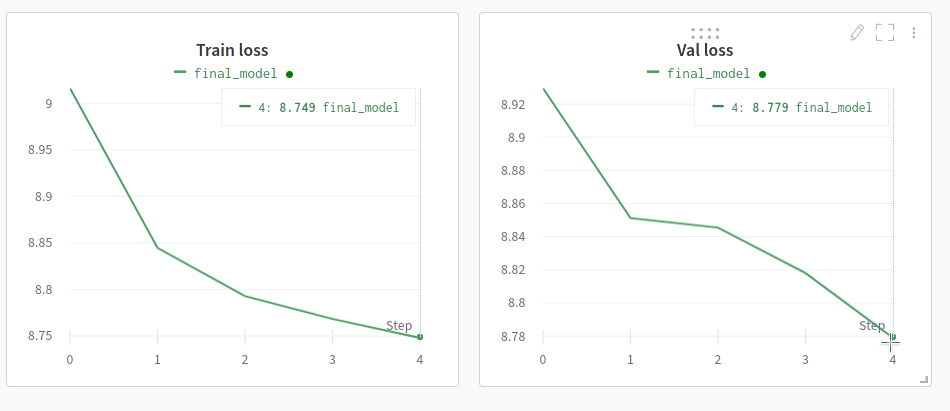